In [1]:
import os
import numpy as np
from tqdm import tqdm
import pickle
import networkx as nx
import editdistance # see https://pypi.python.org/pypi/editdistance

### processing

We first need to resolve references among papers in the user's base

In [2]:
papers_data = pickle.load(open('papers_data.pkl', 'rb'))

In [3]:
# lets collec all papers and their references into one array, type = 1 means paper is in the user's base, 0 - only in references
all_papers = []
for k in papers_data:
    all_papers.append(papers_data[k]['metadata'])
    all_papers[-1]['type'] = 1
    for ref in papers_data[k]['references']:
        all_papers.append(ref)
        all_papers[-1]['type'] = 0 

In [4]:
# filter papers without titles
no_title = 0
none_title = 0
filtered_papers = []
for i in range(len(all_papers)):
    if 'title' not in all_papers[i]:
        no_title += 1
    elif all_papers[i]['title'] == '<None>':
        none_title += 1
    else:
        filtered_papers.append(all_papers[i])
print(no_title, none_title)
print(len(filtered_papers))

13 1293
13455


In [5]:
# let's get rid of papers without titles
all_papers = filtered_papers

In [6]:
# likely a stub
# papers are considered to be duplicates if the edit-distance between their titles is less than "threshold * minimal_title_legngth"
def is_duplicate(p1, p2, threshold = 0.25):
    if 'title' in p1 and 'title' in p2:
        if editdistance.eval(p1['title'], p2['title']) < threshold * min(len(p1['title']), len(p2['title'])):
            return True
    return False

In [7]:
# resolving duplicates and links
# Note: O(N^2), for 10k papers takes ~ 5 min
resolved_papers = []
all_cnt_duplicates = []
for i in tqdm( range(len(all_papers))):
    cnt_duplicates = 0
    for j in range(len(resolved_papers)):
        if is_duplicate(all_papers[i], resolved_papers[j]):
            cnt_duplicates += 1
            all_papers[i]['id'] = j
            if all_papers[i]['type'] == 0 and resolved_papers[j]['type'] == 1: # if referenced paper is in the user's base, mark it
                all_papers[i]['type'] = 1
    all_cnt_duplicates.append(cnt_duplicates)
    if cnt_duplicates == 0:
        all_papers[i]['id'] = len(resolved_papers)
        resolved_papers.append(all_papers[i])

100%|██████████| 13455/13455 [06:55<00:00, 32.36it/s]


In [8]:
from collections import Counter
Counter(all_cnt_duplicates).most_common(10) # if the counter has values larger than 1, there are ambiguities (it is not good to have them)

[(0, 8698), (1, 4716), (2, 30), (3, 11)]

In [22]:
# store processed papers_data in order to skip processing steps
pickle.dump(papers_data, open('papers_data_processed.pkl', 'wb'))

---

In [23]:
papers_data = pickle.load(open('papers_data_processed.pkl', 'rb'))

In [24]:
import string
# split long string into lines, also replace not printable characters with their representations
def split_long(s, split_length = 20, clip_size = 100):
    s = ''.join(x if x in string.printable else repr(x) for x in s)
    if clip_size is not None:
        s = s[:clip_size]
    split_s = s.split(' ')
    res_s = ''
    cur_length = 0
    for i in range(len(split_s)):
        if cur_length > split_length:
            res_s += '\n'
            cur_length = 0
        res_s += split_s[i] + ' '
        cur_length += len(split_s[i])
    return res_s
    

### create citation graph and plot it

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [26]:
import seaborn as sns

In [27]:
node_degrees = []
codes = {}
for p in papers_data.values():
    if 'id' in p['metadata']:
        if p['metadata']['id'] not in codes: # and len(added_nodes) < 20:
            codes[p['metadata']['id']] = len(codes)
            node_degrees.append(0)
        for ref in p['references']:
            if 'id' in ref:
                if ref['id'] not in codes:
                    codes[ref['id']] = len(codes)
                    node_degrees.append(0)
                node_degrees[codes[p['metadata']['id']]] += 1
                node_degrees[codes[ref['id']]] += 1
node_degrees = np.array(node_degrees)

In [28]:
MIN_REFERENCES = 5 # include in the graph only papers with at least this amount references from the user's base

In [29]:
G=nx.DiGraph()
node_labels = {}
list_nodes = []
node_colors = []
added_nodes = {}
for p in tqdm(papers_data.values()):
    if 'id' in p['metadata']:
        if p['metadata']['id'] not in added_nodes: # and len(added_nodes) < 20:
            added_nodes[p['metadata']['id']] = len(added_nodes)
            G.add_node(p['metadata']['id'])
            list_nodes.append(p['metadata']['id'])
            node_colors.append('red' if p['metadata']['type'] == 1 else 'black')
            node_labels[p['metadata']['id']] = split_long(p['metadata']['title'])
            
        for ref in p['references']:
            if 'id' in ref and node_degrees[codes[ref['id']]] >= MIN_REFERENCES:
                if ref['id'] not in added_nodes:
                    added_nodes[ref['id']] = len(added_nodes)
                    G.add_node(ref['id'])
                    list_nodes.append(ref['id'])
                    node_colors.append('red' if ref['type'] == 1 else 'black')
                    node_labels[ref['id']] = split_long(ref['title'])
                G.add_edge(p['metadata']['id'], ref['id'], weight = 1)
                
                

100%|██████████| 288/288 [00:00<00:00, 21663.16it/s]


In [30]:
for p in tqdm(papers_data.values()):
    if 'id' in p['metadata'] and p['metadata']['id'] in added_nodes:
        node_colors[added_nodes[p['metadata']['id']]] = 'red'

100%|██████████| 288/288 [00:00<00:00, 673333.08it/s]


In [76]:
for edge in G.edges():
    if node_colors[added_nodes[edge[0]]] == node_colors[added_nodes[edge[1]]] and node_colors[added_nodes[edge[0]]] == 'black':
        print(edge)
        print(node_colors[added_nodes[edge[0]]], node_colors[added_nodes[edge[1]]])
        break

In [31]:
len(added_nodes)

472

#### try plot with spring layout

In [82]:
pos = nx.spring_layout(G, iterations = 30, k = 0.1)

/usr/local/lib/python3.4/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning:

pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.

/usr/local/lib/python3.4/dist-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning:

pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:917: UserWarning:

axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.

/usr/local/lib/python3.4/dist-packages/matplotlib/rcsetup.py:152: UserWarning:

axes.hold is deprecated, will be removed in 3.0



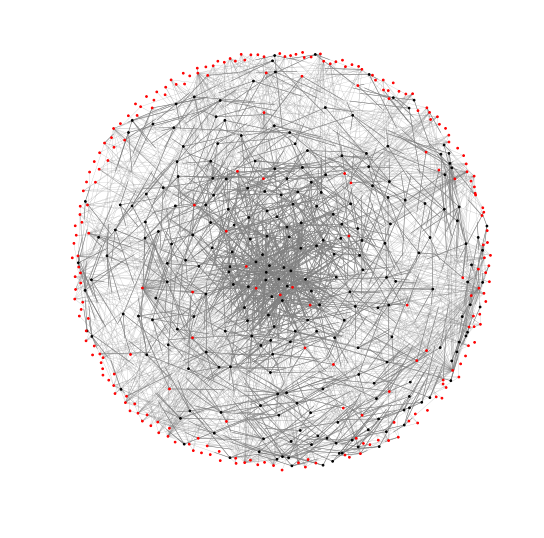

In [83]:
plt.figure(figsize = (7, 7))
nx.draw(G, pos, node_size=3, width=0.15, node_color=[node_colors[added_nodes[node]] for node in G.nodes()], 
        with_labels=False, edge_color='gray');

since spring layout is not good at semantic clustering papers, we will try to use node2vec library : https://github.com/aditya-grover/node2vec

In [34]:
import node2vec.src.node2vec as n2v
import node2vec
from gensim.models import Word2Vec

In [35]:
# we make an undirected representation of the directed graph with spliting original vertices into "in" and "out" ones
graph = nx.Graph()

for i in range(len(list_nodes)):
    graph.add_node(str(added_nodes[list_nodes[i]]))
    graph.add_node('~' + str(added_nodes[list_nodes[i]]))
    graph.add_edge('~' + str(added_nodes[list_nodes[i]]), str(added_nodes[list_nodes[i]]), weight = 1)
    
for edge in G.edges():
    graph.add_edge(str(added_nodes[edge[0]]), '~' + str(added_nodes[edge[1]]), weight = 1)
    

In [52]:
g = n2v.Graph(graph, False, 1, 1)
g.preprocess_transition_probs()

# Note: the library node2vec is for python 2, you will need to remove some "print" statements out of the simulate_walks method
walks = g.simulate_walks(20, 30)

In [53]:
model = Word2Vec(walks, size=50, window=10, min_count=0, sg=1, workers=1, iter=1)
word_vectors = model.wv

In [54]:
Y = np.array([word_vectors[str(added_nodes[list_nodes[i]])] for i in range(len(list_nodes))])

In [60]:
# node2vec works better when it embeds nodes into high-dimensional space, then we will embed their representations into 2d with TSNE
from sklearn.manifold import TSNE

In [57]:
tsne = TSNE(n_components=2, perplexity=15, learning_rate = 700)

In [58]:
Y = (Y.T/np.linalg.norm(Y, axis = 1)).T
Y = tsne.fit_transform(Y)

In [84]:
for i in range(len(Y)):
    pos[list_nodes[i]] = Y[i]

/usr/local/lib/python3.4/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning:

pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.

/usr/local/lib/python3.4/dist-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning:

pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:917: UserWarning:

axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.

/usr/local/lib/python3.4/dist-packages/matplotlib/rcsetup.py:152: UserWarning:

axes.hold is deprecated, will be removed in 3.0



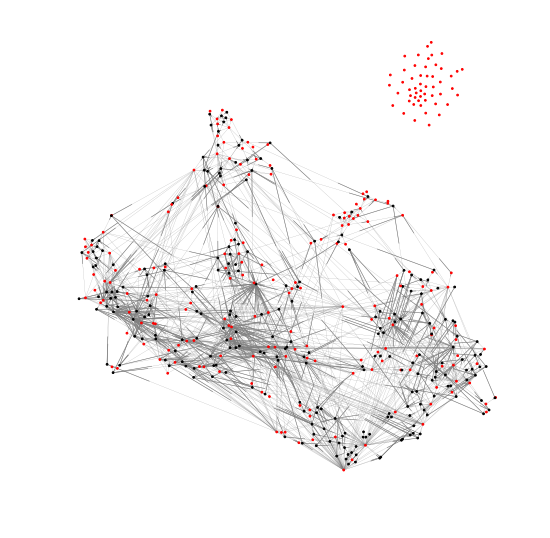

In [85]:
plt.figure(figsize = (7, 7))
nx.draw(G, pos, node_size=3, width=0.15, node_color=[node_colors[added_nodes[node]] for node in G.nodes()], 
        with_labels=False, edge_color='gray');

### interactive visualization with plotly

In [63]:
import plotly.plotly as py
from plotly.graph_objs import *
# you need to set up the connection to plotly API : https://plot.ly/python/getting-started/#initialization-for-online-plotting

In [89]:
edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=5,
        line=dict(width=1)))


for i in range(len(G.nodes())):
    x, y = pos[list_nodes[i]]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_trace['marker']['color'].append(node_colors[i])
    node_info = node_labels[list_nodes[i]]
    node_trace['text'].append(node_info)

In [90]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Interactive citation graph',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                width=750,
                height=750,
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='networkx_3')

/usr/local/lib/python3.4/dist-packages/plotly/tools.py:1341: UserWarning:

Looks like you used a newline character: '\n'.

Plotly uses a subset of HTML escape characters
to do things like newline (<br>), bold (<b></b>),
italics (<i></i>), etc. Your newline characters 
have been converted to '<br>' so they will show 
up right on your Plotly figure!

